In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.nn import functional as F
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

import pickle as pk
from PIL import Image
import random

PyTorch Version:  1.0.0
Torchvision Version:  0.2.1


In [2]:
# Detect if we have a GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:',device)

batch_size = 8

device: cuda


In [3]:
from torch.utils.data import Dataset, DataLoader
def dataLoader():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # mean = [0.485, 0.456, 0.406]  std = [0.229, 0.224, 0.225]
    test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])
    Gallery_dataset = datasets.ImageFolder(root='../数据集/UCMerced_LandUse/data/test', transform=test_augs)
#     Gallery_dataset = datasets.ImageFolder(root='../数据集/Google dataset of SIRI-WHU_earth_im_tiff/12class_tif', transform=test_augs)
    return Gallery_dataset
Gallery_dataset = dataLoader()
Gallery_loader = DataLoader(Gallery_dataset,
                           batch_size, shuffle=False)

In [4]:
import math
# rmac 
def rmac(x, L=3, eps=1e-6):
    ovr = 0.4 # desired overlap of neighboring regions
    steps = torch.Tensor([2, 3, 4, 5, 6, 7]) # possible regions for the long dimension

    W = x.size(3)
    H = x.size(2)

    w = min(W, H)
    w2 = math.floor(w/2.0 - 1)

    b = (max(H, W)-w)/(steps-1)
    (tmp, idx) = torch.min(torch.abs(((w**2 - w*b)/w**2)-ovr), 0) # steps(idx) regions for long dimension

    # region overplus per dimension
    Wd = 0;
    Hd = 0;
    if H < W:  
        Wd = idx.item() + 1
    elif H > W:
        Hd = idx.item() + 1

    v = F.max_pool2d(x, (x.size(-2), x.size(-1)))
    v = v / (torch.norm(v, p=2, dim=1, keepdim=True) + eps).expand_as(v)

    for l in range(1, L+1):
        wl = math.floor(2*w/(l+1))
        wl2 = math.floor(wl/2 - 1)

        if l+Wd == 1:
            b = 0
        else:
            b = (W-wl)/(l+Wd-1)
        cenW = torch.floor(wl2 + torch.Tensor(range(l-1+Wd+1))*b) - wl2 # center coordinates
        if l+Hd == 1:
            b = 0
        else:
            b = (H-wl)/(l+Hd-1)
        cenH = torch.floor(wl2 + torch.Tensor(range(l-1+Hd+1))*b) - wl2 # center coordinates
            
        for i_ in cenH.tolist():
            for j_ in cenW.tolist():
                if wl == 0:
                    continue
                R = x[:,:,(int(i_)+torch.Tensor(range(wl)).long()).tolist(),:]
                R = R[:,:,:,(int(j_)+torch.Tensor(range(wl)).long()).tolist()]
                vt = F.max_pool2d(R, (R.size(-2), R.size(-1)))
                vt = vt / (torch.norm(vt, p=2, dim=1, keepdim=True) + eps).expand_as(vt)
                v += vt

    return v
# RMAC 类
class RMAC(nn.Module):

    def __init__(self, L=3, eps=1e-6):
        super(RMAC,self).__init__()
        self.L = L
        self.eps = eps

    def forward(self, x):
        return rmac(x, L=self.L, eps=self.eps)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'L=' + '{}'.format(self.L) + ')'

In [5]:
## 加载模型：resnet34_whurisi_remote_finetune_
pretrained_net = models.vgg16_bn(pretrained=False)
pretrained_net.features.add_module('pool',RMAC())
pretrained_net.classifier = nn.Linear(512, 21)

PATH = "./my_model/rmac_UcRemote_vgg16_fine-tune.pt"
pretrained_net.load_state_dict(torch.load(PATH))

In [6]:
pretrained_net = pretrained_net.to(device)
pretrained_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [7]:
# import math
# # rmac 
# def rmac(x, L=3, eps=1e-6):
#     ovr = 0.4 # desired overlap of neighboring regions
#     steps = torch.Tensor([2, 3, 4, 5, 6, 7]) # possible regions for the long dimension

#     W = x.size(3)
#     H = x.size(2)

#     w = min(W, H)
#     w2 = math.floor(w/2.0 - 1)

#     b = (max(H, W)-w)/(steps-1)
#     (tmp, idx) = torch.min(torch.abs(((w**2 - w*b)/w**2)-ovr), 0) # steps(idx) regions for long dimension

#     # region overplus per dimension
#     Wd = 0;
#     Hd = 0;
#     if H < W:  
#         Wd = idx.item() + 1
#     elif H > W:
#         Hd = idx.item() + 1

#     v = F.max_pool2d(x, (x.size(-2), x.size(-1)))
#     v = v / (torch.norm(v, p=2, dim=1, keepdim=True) + eps).expand_as(v)

#     for l in range(1, L+1):
#         wl = math.floor(2*w/(l+1))
#         wl2 = math.floor(wl/2 - 1)

#         if l+Wd == 1:
#             b = 0
#         else:
#             b = (W-wl)/(l+Wd-1)
#         cenW = torch.floor(wl2 + torch.Tensor(range(l-1+Wd+1))*b) - wl2 # center coordinates
#         if l+Hd == 1:
#             b = 0
#         else:
#             b = (H-wl)/(l+Hd-1)
#         cenH = torch.floor(wl2 + torch.Tensor(range(l-1+Hd+1))*b) - wl2 # center coordinates
            
#         for i_ in cenH.tolist():
#             for j_ in cenW.tolist():
#                 if wl == 0:
#                     continue
#                 R = x[:,:,(int(i_)+torch.Tensor(range(wl)).long()).tolist(),:]
#                 R = R[:,:,:,(int(j_)+torch.Tensor(range(wl)).long()).tolist()]
#                 vt = F.max_pool2d(R, (R.size(-2), R.size(-1)))
#                 vt = vt / (torch.norm(vt, p=2, dim=1, keepdim=True) + eps).expand_as(vt)
#                 v += vt

#     return v
# # RMAC 类
# class RMAC(nn.Module):

#     def __init__(self, L=3, eps=1e-6):
#         super(RMAC,self).__init__()
#         self.L = L
#         self.eps = eps

#     def forward(self, x):
#         return rmac(x, L=self.L, eps=self.eps)
        
#     def __repr__(self):
#         return self.__class__.__name__ + '(' + 'L=' + '{}'.format(self.L) + ')'

In [8]:
pretrained_net.classifier = nn.Sequential()

In [9]:
pretrained_net.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNor

In [10]:
# save to loacl file
# save_path = './features/maxPooling_UcRemote21-train-resnet'
save_path = './features/train_vgg16_rmac_pool_UcRemote21-train-resnet'

def save_data(file, data):
    f = open(file, 'wb+')
    pk.dump(data, f, 0)
    f.close()


def extract_features(model, loader):
    since = time.time()
    features = torch.FloatTensor()
         
    model.eval()

    # Iterate over data.
    for inputs, labels in loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        ff = outputs.data.cpu()
        # norm feature
        fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
        ff = ff.div(fnorm.expand_as(ff))
        features = torch.cat((features, ff), 0)

    time_elapsed = time.time() - since
    print('Feature extraction complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return features

if os.path.exists(save_path):
    fo = open(save_path, 'rb')
    features = pk.load(fo, encoding='bytes')
    fo.close()
    print("Load features.")
else:
    features = extract_features(pretrained_net, Gallery_loader)
    save_data(save_path, features)
    print("Save features to %s" % (save_path))

Feature extraction complete in 0m 8s
Save features to ./features/train_vgg16_rmac_pool_UcRemote21-train-resnet


In [11]:
features[0].shape

torch.Size([512])

In [12]:
# 封装距离比较函数
def similarity_of_two(img_data1, img_data2):
    out = (img_data1*img_data2)
    return out.sum()

# 计算目标图片与数据库中每张图像的余弦相似度
def search_similar(target, features):
    record = []
    for i in range(len(features)):
        record.append(similarity_of_two(target, features[i]) )
    return record

In [13]:
similarity_of_two(features[0], features[1])

tensor(0.9769)

In [14]:
# 提取目标图像的特征  修
def query_feature(input):
    x = input

    x = x.unsqueeze(dim=0)
    x.requires_grad = False

    x.to(device)
    pretrained_net.to('cpu')
    pretrained_net.eval()
    
    pre = pretrained_net(x)
    pre = pre.data.cpu()
    # norm feature
    prenorm = torch.norm(pre, p=2, dim=1, keepdim=True)
    pre = pre.div(prenorm.expand_as(pre))
    return pre

In [15]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def tensor2image(data):
    # 因为做了归一化，要返回标准tensor
    for i in range(len(data)): # (x-m)/s = y   x = 
        data[i] = data[i] * std[i] + mean[i]
    img = transforms.ToPILImage()(data).convert('RGB')
    plt.imshow(img)

In [16]:
# mAP... and  准确率 k = 5 10 20
def compute_AP_and_P(list, label):
    P_three = []
    true_size = 0.0
    AP = 0.0
    num = 1
    for i in range(len(list)):
#         if num == 19: # 在这里正例总共20个
#             break
        # 排除自身这张图片
        if i == 0:
            continue
        if list[i] == label:
            true_size += 1.
            AP += true_size / (i)
#             num = num + 1
        if i == 5:
            P_three.append(true_size/(i))
        if i == 10:
            P_three.append(true_size/(i))
        if i == 20:
            P_three.append(true_size/(i))
    if true_size == 0.0:
        return 0
    return AP/true_size, P_three

target label: 12
found label : 12 12 12 12 12 6 12 6 6 12 12 6 6 12 12 12 12 12 12 12 12 12 12 13 13 18 6 6 6 6 13 6 4 12 4 13 6 13 18 13 (0.7670800936345311, [0.8, 0.7, 0.75])


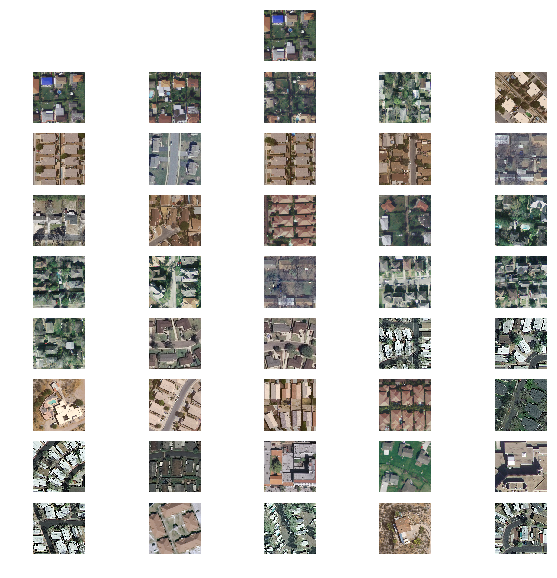

In [17]:
# for _ in range(3): # 搜三张试试吧
# k = random.randint(0, len(Gallery_dataset))  # 420张图中随机选一张测试
k = 250
plt.subplots(figsize=(10, 10))
print("target label:",Gallery_dataset[k][1])
plt.subplot(9,5,3)
tensor2image(Gallery_dataset[k][0])
plt.axis('off')

pre = query_feature(Gallery_dataset[k][0])
res = search_similar(pre, features)
sim = np.argsort(res)[-40:]  # 取最相似的20张  40

preLabelList = []
i = 6
print('found label : ',end='')
for index in range(len(sim)):
    re = sim[len(sim)-1-index]
    plt.subplot(9, 5, i)      
    tensor2image(Gallery_dataset[re][0])
    print('%s ' % (Gallery_dataset[re][1]),end='')
    preLabelList.append(Gallery_dataset[re][1])
    i += 1
    plt.axis('off')
print(compute_AP_and_P(preLabelList, Gallery_dataset[k][1]))
plt.show()

## rmac

In [18]:
# mAP
import time
sum_AP = 0.0
P_three_sum = [0,0,0]
time_start = time.time()
for k in range(len(Gallery_dataset)): # 对所有图片进行搜索 420  21*20

#     k = random.randint(0, len(Gallery_dataset))  # 2400张图中随机选一张测试
    pre = query_feature(Gallery_dataset[k][0])
    res = search_similar(pre, features)
#     sim = np.argsort(res)[-40:]  # 返回前40张
    sim = np.argsort(res)[:]  # 排序

    preLabelList = []
#     i = 6
#     print('found label : ',end='')
    for index in range(len(sim)):
        re = sim[len(sim)-1-index]
#         plt.subplot(9, 5, i)      
#         tensor2image(Gallery_dataset[re][0])
#         print('%s ' % (Gallery_dataset[re][1]),end='')
        preLabelList.append(Gallery_dataset[re][1])
#         i += 1
#         plt.axis('off')
#     plt.show()
    AP, P_three = compute_AP_and_P(preLabelList, Gallery_dataset[k][1])
    if k % 50 == 0:
        print('k: ', k ,'label: ', Gallery_dataset[k][1], 'AP: ', AP)
    sum_AP += AP
    for i in range(3):
        P_three_sum[i] += P_three[i]
time_end = time.time()
print('Time cost = %fs' % (time_end - time_start))
mAP = sum_AP / len(Gallery_dataset)
P_three_mean = [0,0,0]
for i in range(3):
    P_three_mean[i] = P_three_sum[i]/len(Gallery_dataset)

k:  0 label:  0 AP:  1.0
k:  50 label:  2 AP:  0.9602560505505755
k:  100 label:  5 AP:  1.0
k:  150 label:  7 AP:  1.0
k:  200 label:  10 AP:  0.9945983379501384
k:  250 label:  12 AP:  0.7433741237941172
k:  300 label:  15 AP:  1.0
k:  350 label:  17 AP:  0.9949874686716792
k:  400 label:  20 AP:  1.0
Time cost = 1063.261047s


In [19]:
mAP

0.8578619256585643

In [20]:
P_three_mean

[0.9309523809523815, 0.8957142857142857, 0.7832142857142838]

## max_pool

In [17]:
mAP

0.8162471755575854

In [18]:
P_three_mean

[0.9223809523809527, 0.8733333333333336, 0.7319047619047613]

##  avg

In [17]:
mAP

0.8445269204753266

In [18]:
P_three_mean

[0.942857142857143, 0.8992857142857144, 0.7605952380952369]